In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("vis/hoechstgan_basic_2qxrg3f7_test__metrics.csv")
df.describe()

,CD3+ cells,CD3 real MIR,CD3 fake MIR,CD3 relative MIR,CD8+ cells,CD8 real MIR,CD8 fake MIR,CD8 relative MIR
count,4880.000000,4801.000000,4801.000000,4800.000000,4880.000000,4081.000000,4080.000000,4080.000000
mean,4.979098,19.344376,213.600646,11.029955,3.273975,8.037556,58.410504,4.914229
std,4.108985,129.526402,3433.650124,254.072877,3.364046,11.148661,884.037782,56.521789
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,8.751435,5.026796,0.451226,1.000000,4.531718,3.200984,0.568642
50%,4.000000,12.654789,9.081493,0.779839,2.000000,6.173827,5.309432,0.914504
75%,7.000000,19.643873,24.275234,1.743083,5.000000,8.803667,11.152343,1.674938
max,36.000000,8865.395508,170192.380000,15808.820312,28.000000,482.335327,41747.156000,2454.824463


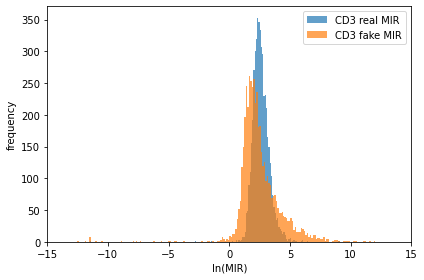

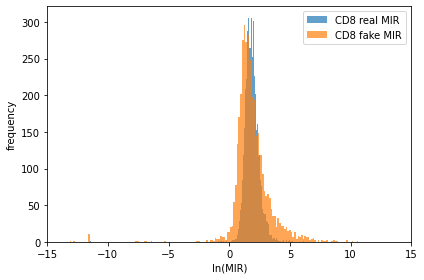

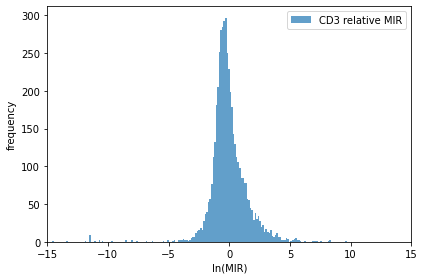

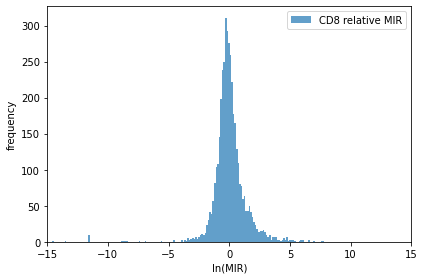

In [3]:
def plot_hist(col, color=None):
    x = np.array(df[col])
    x = x[~np.isnan(x)]
    x[x == 0] = 1e-5
    x = np.log(x)
    plt.hist(x, bins=200, alpha=.7, label=col, color=color)
    plt.xlim(-15, 15)
    plt.xlabel("ln(MIR)")
    plt.ylabel("frequency")
    plt.tight_layout()

plt.figure()
plot_hist("CD3 real MIR")
plot_hist("CD3 fake MIR")
plt.legend()
plt.savefig("mir_real_fake_cd3.png")

plt.figure()
plot_hist("CD8 real MIR")
plot_hist("CD8 fake MIR")
plt.legend()
plt.savefig("mir_real_fake_cd8.png")

plt.figure()
plot_hist("CD3 relative MIR")
plt.legend()
plt.savefig("mir_relative_cd3.png")

plt.figure()
plot_hist("CD8 relative MIR")
plt.legend()
plt.savefig("mir_relative_cd8.png")